# Importing modules
First, we will import the necessary libraries and read in the CSV data:

In [1]:
pip install fracdiff

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [3]:
# Read in the CSV data
df = pd.read_csv('/kaggle/input/stock-market-data/stock_market_data/sp500/csv/AAPL.csv')
df

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492
...,...,...,...,...,...,...,...
10585,06-12-2022,141.919998,147.070007,64727200,147.300003,142.910004,142.910004
10586,07-12-2022,140.000000,142.190002,69721100,143.369995,140.940002,140.940002
10587,08-12-2022,141.100006,142.360001,62128300,143.520004,142.649994,142.649994
10588,09-12-2022,140.899994,142.339996,76069500,145.570007,142.160004,142.160004


In [4]:
def create_sequences(data, t, y_step):
    X, y = [], []
    for i in range(0,len(data)-t-y_step-1):
        X.append(data.iloc[i:i+t, :].values)
        y.append(data.iloc[i + t: i+t+y_step, :]["Close"].values)
    return np.array(X), np.array(y)

In [5]:
from fracdiff.sklearn import FracdiffStat
def frac_diff_stationarity(train, test):
    # Make a copy of the train data inside the function to avoid modifying the original dataframe
    train_internal_copy = train.copy()
    
    fd = FracdiffStat()
    fd.fit(train_internal_copy[['Close']].values)
    
    # Replace the 'Close' column with the transformed data in the copy
    train_internal_copy['Close'] = fd.transform(train_internal_copy[['Close']].values)
    test['Close'] = fd.transform(test[['Close']].values)
    
    # Return the modified copy and test
    return train_internal_copy, test

In [6]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df.drop(columns=["Date", "Adjusted Close"], inplace=True)

In [7]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.9)
val_size = int(len(df) * 0.05)
train = df.iloc[:train_size, :]
val = df.iloc[train_size : train_size + val_size, :]
test = df.iloc[train_size + val_size :, :]

In [8]:
train_copy = train.copy()
train, val = frac_diff_stationarity(train, val)
train, test = frac_diff_stationarity(train_copy, test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
# Select all columns except 'Close'
features_to_standardize = [column for column in train.columns if column != 'Close']

# Calculate the mean and standard deviation only for the required columns
train_mean = train[features_to_standardize].mean()
train_std = train[features_to_standardize].std()

# Standardize only the required columns in the train, validation, and test sets
train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
X_train, y_train = create_sequences(train, 22, 1)
X_val, y_val = create_sequences(val, 22, 1)
X_test, y_test = create_sequences(test, 22, 1)

In [11]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((9507, 22, 8), (9507, 1), (505, 22, 8), (505, 1), (506, 22, 8), (506, 1))

In [12]:
'''
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
'''

'\nX_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))\nX_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))\nX_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))\n'

In [13]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

seed=42

def build_LSTM_regressor(input_shape, output_units):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    #1D
    cnn = tfkl.Conv1D(1024,3,padding='same')(input_layer)
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same')(cnn)
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    
    lstm = tfkl.LSTM(1024, return_sequences=True)(cnn)
    lstm = tfkl.LSTM(256)(lstm)
    
    # Feature extractor
    regressor = tfkl.Dense(1024)(lstm)
    regressor = tfkl.LeakyReLU(alpha=0.2)(regressor)
    regressor = tfkl.Dense(512)(regressor)
    regressor = tfkl.LeakyReLU(alpha=0.2)(regressor)
    regressor = tfkl.Dense(256)(regressor)
    regressor = tfkl.LeakyReLU(alpha=0.2)(regressor)
    dropout = tfkl.Dropout(.3, seed=seed)(regressor)
    

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(dropout)  # No activation for regression

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='LSTM_regressor')

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    # Return the model
    return model

# Assuming input_shape is (t, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1]  # Number of days to predict

# Build and compile the model
model = build_LSTM_regressor(input_shape, output_units)
model.summary()

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-4)
    ]
).history

Model: "LSTM_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 22, 8)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 1024)          25600     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 22, 1024)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 1024)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 256)           786688    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 256)         

In [14]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel
from tensorflow.keras.regularizers import l1_l2

def build_LSTM_regressor_v2(input_shape, output_units):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Reduced complexity of LSTM layers
    lstm = tfkl.LSTM(512, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)

    # Regularization added to Dense layers
    regressor = tfkl.Dense(512, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(lstm)
    regressor = tfkl.LeakyReLU(alpha=0.2)(regressor)
    regressor = tfkl.Dense(256, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(regressor)
    regressor = tfkl.LeakyReLU(alpha=0.2)(regressor)
    dropout = tfkl.Dropout(0.3, seed=42)(regressor)

    output_layer = tfkl.Dense(output_units)(dropout)  # No activation for regression

    model = tfkModel(inputs=input_layer, outputs=output_layer, name='LSTM_regressor_v2')
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

def train_model_v2(model, X_train, y_train, X_val, y_val):
    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        batch_size=4,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-5)
        ]
    ).history
    return history

# Assuming input_shape is (t, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1]  # Number of days to predict

# Assuming input_shape and output_units are defined as in the original notebook
# Build and compile the updated model
model_v2 = build_LSTM_regressor_v2(input_shape, output_units)

# Output the updated model summary
model_v2.summary()

# Train the updated model
history_v2 = train_model_v2(model_v2, X_train, y_train, X_val, y_val)




Model: "LSTM_regressor_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 22, 8)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 22, 512)           1067008   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)         

In [15]:
test_loss = model_v2.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Mean Squared Error): {test_loss}")

16/16 [==============================] - 0s 4ms/step - loss: 9.1117 - mae: 2.3300
Test Loss (Mean Squared Error): [9.111650466918945, 2.330012321472168]


In [16]:
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Mean Squared Error): {test_loss}")

16/16 [==============================] - 0s 7ms/step - loss: 9.4299 - mae: 2.3867
Test Loss (Mean Squared Error): [9.429947853088379, 2.386692523956299]


In [21]:
predictions = model.predict(X_test)

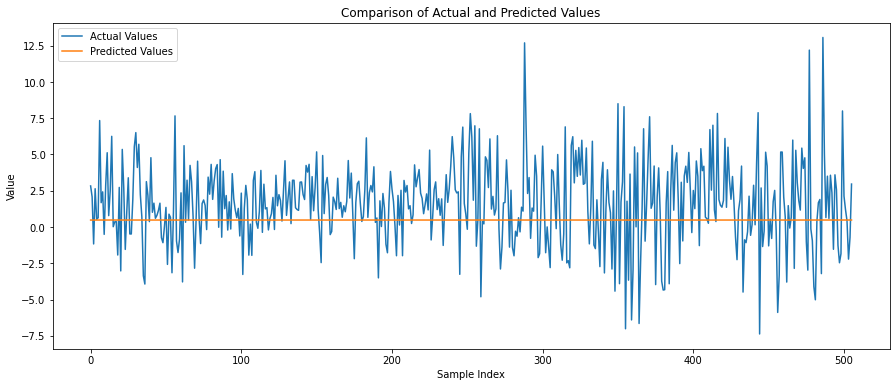

In [22]:
# Select a portion of data to plot, e.g., first 100 samples


# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()
